<b>Credit Card Project Part IV: More Tests and Simulations</b>

This project uses credit card data for 30,000 anonymous credit card clients in Taiwan. It presents information on the customers (education, sex, marital status, age) and information about customer behavior for a six-month period from April 2005 to September 2005. [The information was downloaded in CSV format from Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset), and according to the information provided it was uploaded from the UC Irvine Machine Learning Repository.

In order to keep the amount of information manageable, I have split the project into four parts. [<b>Part I</b>](https://github.com/dr-mentaculus/Credit-Card-Project/blob/main/credit_card_ml_clarity.ipynb) focuses on Machine Learning algorithms and Feature Engineering. [<b>Part II</b>](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_part_II.ipynb), uses tests and simulations to uncover possible evidence of gender bias in how customers are being flagged as at risk. (**NOTE:** This interpretation depends on a working hypothesis that I offer support for, but which I am not in a position to confirm.) [**PART III**](https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/credit_card_Part_III.ipynb) experiments with more machine learning, and builds a more easily interpreted logisitic regression model. **PART IV**, presented here, is more just me having fun. I'm looking at data for which statistical tests might be misleading, because the data does not meet the assumptions of the relevant test. This lets me compare the results of a statistical test with those of a bootstrap or permutation simulation, to see if the simulation verifies the test results or not.

*This project, I will admit, does not have much of a point. I like writing simulations--I find it a lot more fun than most other parts of looking at data--and plotting the results in matplotlib. So that's what I'm doing.*

[A PowerPoint summary of all four projects](https://www.dropbox.com/sh/38tcjlw7gb7bvka/AABsPtsNWq7yXZpuBqO1-_qNa?dl=0) is also avaiable.

<b>Goals</b>

As I just said, in this project I'm not really worried about finding out anything interesting about the data. Parts I and II are great for that, if having a point is your thing. I just want to see whether various tests still work when their assumptions aren't met. I want to figure out how to write simulations to test different statistics. And I want to draw stuff in matplotlib. If that's your thing, you may want to skip Part IV. You've been warned.

<b>Inadvertent P-Hacking?</b>

I end up performing a total of 7 statistical tests in the course of this project and Part II. This raises the risk, however, of inadvertent p-hacking. Assuming we set $\alpha$ to .05 in all cases, and the null hypothesis is true in each case, the chance of generating at least one false positive turns out to be $\approx$ 30.2%.

There is a more subtle problem as well. The decision about which tests to perform is not being made prior to looking at the data: I am deciding in many cases to perform tests because something about the data looks surprising.

The first problem can be solved by lowering the value of $\alpha$. If $\alpha = .007$, the chance of producing at least false positive by random chance, assuming the null hypotheses are true in every case, is $\approx$ .048. Because the datasets are large, low p-values should not be hard to come by.

With respect to the second problem, I take some steps to address it in Part II. I'm not going to do anything about it here, though, because I don't really care about whether the sampled values being tested are statistically significant or not. As I've said a few times, I'm just doing this to have fun trying to write simulations and plot graphs. This could all be random data about imaginary monkeys, as far as this project is concerned.

As with project II, I will only work with 10,000 of the 30,000 samples. In this case the reason why is that the p-values start getting extremely small with large sammple sizes, and so the size of the simulations I need to run to find the p-values also get very large. (E.g., if the p-value is .000001, I will need, on average, to run a simulation 1 million times to get a positive result by chance. This takes a while. So I'm trying to cut down on the need for that.)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

starting_data = pd.read_csv("https://github.com/dr-mentaculus/Credit_Card_Project/blob/main/UCI_Credit_Card.csv?raw=True")

#starting_data = pd.read_csv("UCI_Credit_Card.csv")

starting_data.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<b>Some Information on the Columns</b>

The following information about the columns was provided to accompany the Kaggle Dataset. 

(<b>Note</b>: I am only providing information about a few of the columns here. Please see Part 1 for a complete description.)

• LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

• SEX: Gender (1=male, 2=female)

• EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

• MARRIAGE: Marital status (1=married, 2=single, 3=others)

• AGE: Age in years

• default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
hermetically_sealed_data = starting_data.sample(n=20000, replace=False, random_state=211)

starting_data = starting_data[~starting_data.index.isin(hermetically_sealed_data.index)]

len(hermetically_sealed_data), len(starting_data)

(20000, 10000)

<b>Basic Exploratory and Descriptive Statistics</b>

The following cells provide basic descriptive information about some of the relations in the dataset. More interesting statistical tests will come later.

In [4]:
#Renaming categories to make results more readable

df = starting_data[["LIMIT_BAL",
                    "SEX", "EDUCATION", "MARRIAGE", "AGE", "default.payment.next.month"]].copy()

df.SEX.replace({1: "male", 2: "female"}, inplace=True)
df["SEX"] = pd.Categorical(df.SEX)

df.EDUCATION.replace({0: "other_1", 1: "postgraduate", 2: "undergraduate", 3: "secondary", 4: "other_2",
                     5: "other_4", 6: "other_5"}, inplace=True)

df["EDUCATION"] = pd.Categorical(df.EDUCATION, ordered=True, 
                                 categories = ["postgraduate", "undergraduate", "secondary", "other_1", "other_2",
                                               "other_4", "other_5"])

df.MARRIAGE.replace({1: "married", 2: "single", 3: "divorced", 0: "other"}, inplace=True)
df["MARRIAGE"] = pd.Categorical(df.MARRIAGE, ordered=True,
                               categories = ["married", "single", "divorced", "other"])

df.rename(columns={"default.payment.next.month":"defaulted"}, inplace=True)

**ANOVA**

I will start by comparing the relationship between education and a customer's credit limit. Why? Well, it means comparing categorical data with continuous data. In other words, it's an excuse to do ANOVA.

In [5]:
q25 = lambda x: x.quantile(.25)
q75 = lambda x: x.quantile(.77)
r_mean = lambda x: round(np.mean(x), 2)

c = df.groupby("EDUCATION").LIMIT_BAL.agg(["min", q25, "median", q75, "max", r_mean])

c.rename(columns={"min": "min_bal", "<lambda_0>": "first_quart", "median": "median_bal",
                  "<lambda_1>": "third_quart",
                 "max": "max_bal", "<lambda_2>":"mean_bal"}, inplace=True)
c

,min_bal,first_quart,median_bal,third_quart,max_bal,mean_bal
EDUCATION,,,,,,
postgraduate,10000.0,100000.0,200000.0,310000.0,800000.0,214490.03
undergraduate,10000.0,50000.0,120000.0,230000.0,800000.0,149192.27
secondary,10000.0,50000.0,80000.0,200000.0,650000.0,124993.87
other_1,50000.0,125000.0,160000.0,212400.0,270000.0,164285.71
other_2,70000.0,150000.0,190000.0,267300.0,710000.0,219000.00
other_4,10000.0,50000.0,150000.0,230000.0,500000.0,155975.90
other_5,10000.0,50000.0,120000.0,280900.0,540000.0,177142.86


<IPython.core.display.Javascript object>


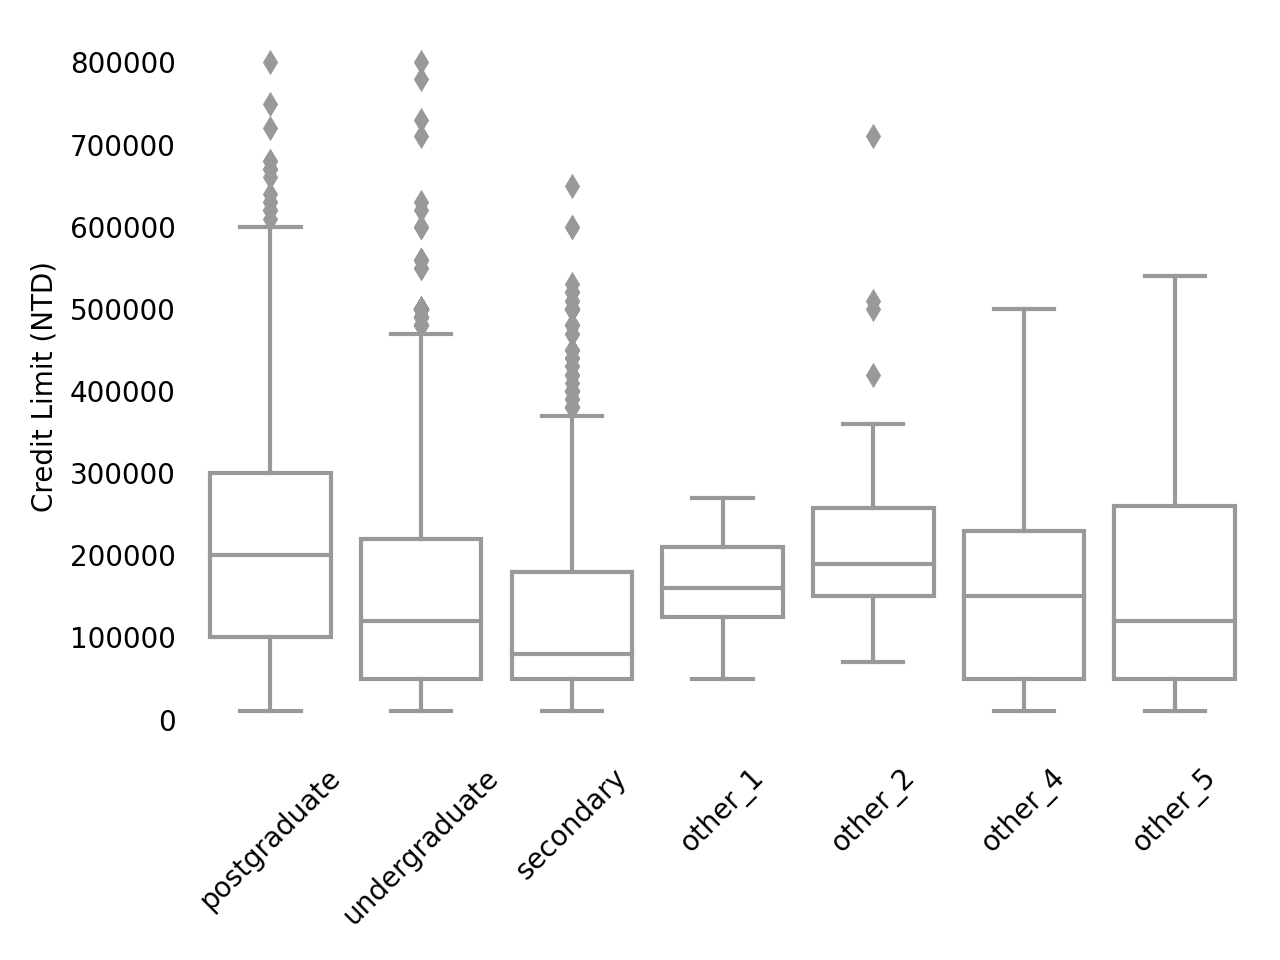

In [6]:
%matplotlib notebook

fig, ax = plt.subplots()

xticklabels = ["postgraduate", "undergraduate", "secondary", "other_1", "other_2",
                                               "other_4", "other_5"]

sns.boxplot(data=df, x="EDUCATION", y="LIMIT_BAL", ax=ax, color="white")
ax.set_xticklabels(labels = xticklabels, rotation=45)
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.ylabel("Credit Limit (NTD)")
plt.xlabel("")
plt.tight_layout()
#plt.savefig("box.png", dpi=300)

<b>Running an f-test</b>

There are obvious differences in the means of the 7 categories. We can use an f-test to determine whether the differences are statistically significant or not. However, the f-test assumes that the values are normally distributed in each of the 7 categories. In this case, that assumption is not met--the data is heavily skewed. This will lead to two simulations, in order to verify the results of the f-test test.

In [7]:
#performing the f-test:

f_test_data = []

for x in ["postgraduate", "undergraduate", "secondary", "other_1", "other_2", "other_4", "other_5"]:
    val = df[df.EDUCATION == x].LIMIT_BAL.values
    f_test_data.append(val)
    


results = st.f_oneway(*f_test_data)

print(f"""
The results of the f-test indicate a statistically significant difference in the means 
of the different groups, with an incredibly low p-value ({results.pvalue:.2g}).
""")


The results of the f-test indicate a statistically significant difference in the means 
of the different groups, with an incredibly low p-value (1.1e-161).



<b>The Two Simulations</b>

The simulations shuffle data to see how often comparable variance in the means could have arisen by chance. The first of these simulations is based on the simulation found in "Practical Statistics for Data Science" (O'Reilly, p. 197).

This simulation assumes, however, a uniform variance for the different groups. This does not match what we see in the data, with some very substantial differences in variance. So I also run a second simulation, which takes a bootstrapping sample from each of the groups, after centering the mean values on zero.

In both cases the p-value from the simulation is considerably higher than for the statistical test.

In [8]:
#As we see here, the data in each category is not normally distributed, nor is the variance between 
#groups reasonably close to uniform.

df.groupby("EDUCATION").LIMIT_BAL.agg(["skew", "var"])

,skew,var
EDUCATION,,
postgraduate,0.623542,1.865420e+10
undergraduate,1.140935,1.461679e+10
secondary,1.492699,1.265015e+10
other_1,-0.207047,5.495238e+09
other_2,2.078121,1.396429e+10
other_4,0.877992,1.475478e+10
other_5,1.085159,2.896044e+10


In [9]:
#simulation one, cribbed from the O'Reilly book

observed_variance = df.groupby("EDUCATION").LIMIT_BAL.mean().var()
simulated_variances = np.zeros(10000)
for i in range(10000):
    rand = np.random.RandomState(seed=(i*13))
    working_df = df[["EDUCATION", "LIMIT_BAL"]].copy()
    working_df["LIMIT_BAL"] = rand.permutation(df.LIMIT_BAL.values)
    variance = working_df.groupby("EDUCATION").mean().var()
    simulated_variances[i] = variance[0]

p1 = np.mean(simulated_variances >= observed_variance)

print(f"""
After 10,000 simulations, the observed variance of the means was found not to be 
statistically significant, an equal or greater variance occuring in the means by 
chance in {100*p1:.1f}% of simulated cases. E.g. p={p1:.3f}.
""")


After 10,000 simulations, the observed variance of the means was found not to be 
statistically significant, an equal or greater variance occuring in the means by 
chance in 12.5% of simulated cases. E.g. p=0.125.



In [10]:
df_centered = df[["EDUCATION", "LIMIT_BAL"]].copy()

ed_vals = ["postgraduate", "undergraduate", "secondary", "other_1", "other_2", "other_4", "other_5"]

data_groups = []

for x in ed_vals:
    copy = df_centered[df_centered.EDUCATION==x].LIMIT_BAL.values
    copy = (copy - np.mean(copy))
    data_groups.append(copy)


ans = np.zeros(10000)

for i in range(10000):
    means = []
    for x in data_groups:
        rand = np.random.RandomState(seed=7*(i+len(x)))
        t = rand.choice(x, size=len(x), replace=True)
        means.append(np.mean(t))
    ans[i] = np.var(means)

p2 = np.mean(ans >= observed_variance)

print(f"""
After 10,000 simulations, the observed variance of the means was found not to be
statistically significant, an equal or greater variance occuring in the means by chance
in {100*p2:.1f}% of simulated cases. E.g. p={p2:.3f}.

This would normally be low enough to qualify as statistically significant.
But \u03B1 for these tests was set at 0.007, in order to avoid inadvertent p-hacking.
""")


After 10,000 simulations, the observed variance of the means was found not to be
statistically significant, an equal or greater variance occuring in the means by chance
in 3.7% of simulated cases. E.g. p=0.037.

This would normally be low enough to qualify as statistically significant.
But α for these tests was set at 0.007, in order to avoid inadvertent p-hacking.



**The Goal Now**

The goal now is to make an awesome graph.

<IPython.core.display.Javascript object>


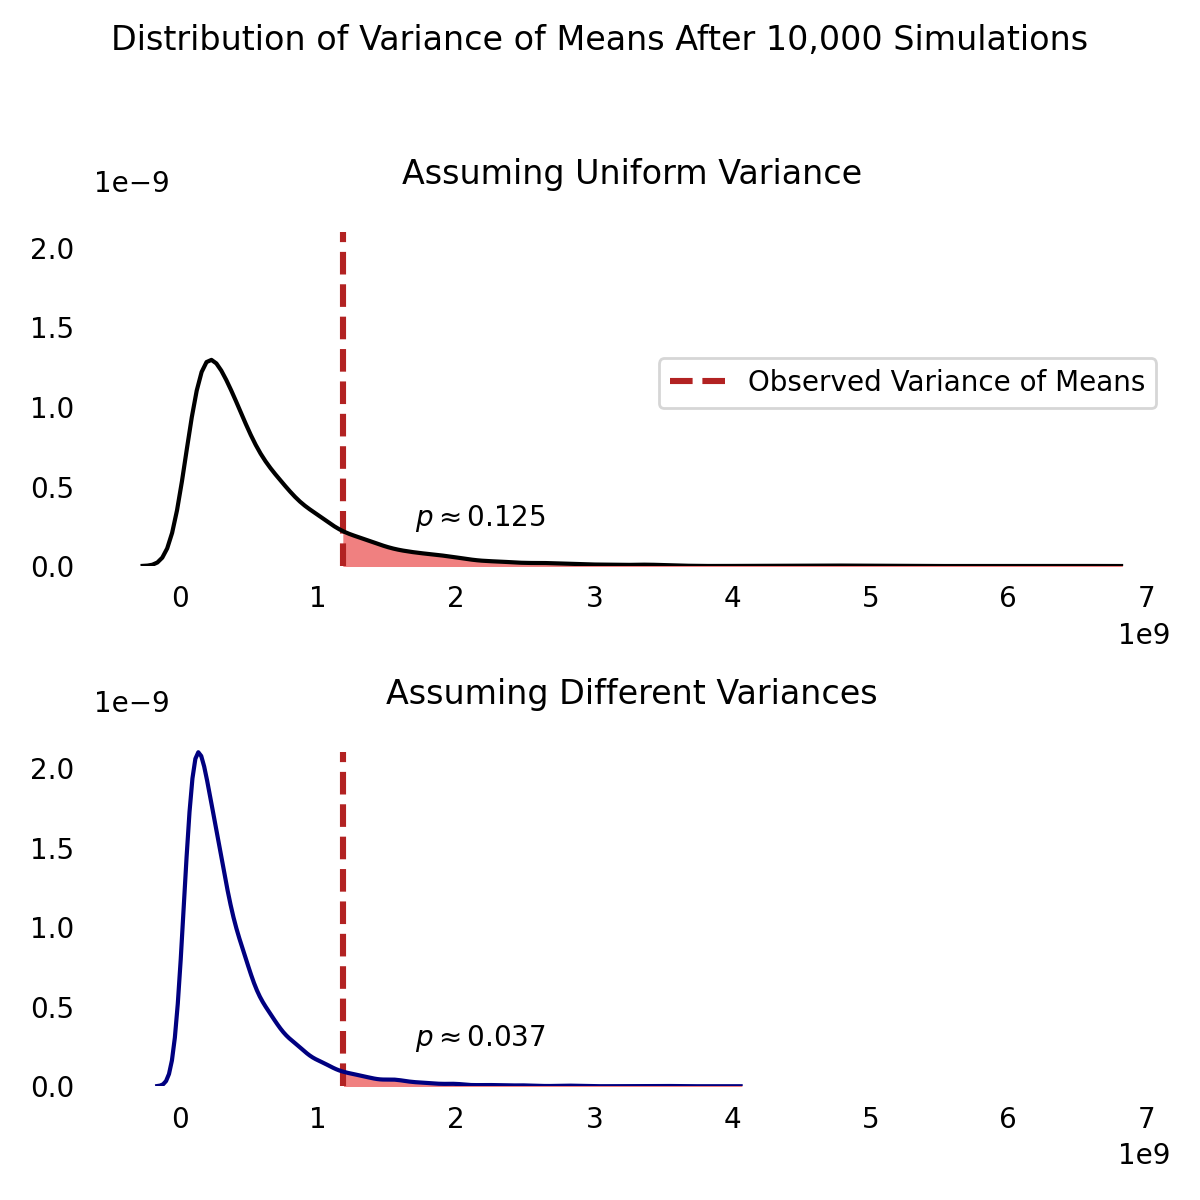

In [17]:
#The following plot compares the two simulations.

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)



#sns.kdeplot(ans, linewidth=.8)
ax1.set_ylim(bottom=0, top=2.3e-9)
ax1.vlines(ymin=0, ymax=2.1e-9, x=observed_variance, color="firebrick", linestyle="--", linewidth=2.2,
          label="Observed Variance of Means")
kde=sns.kdeplot(simulated_variances, color="black", ax=ax1)
line = kde.lines[0]
x, y = line.get_data()
x_fill = x[x>=observed_variance]
y_fill = y[-len(x_fill):]
ax1.fill_between(x=x_fill, y1=0, y2=y_fill, color="lightcoral")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.tick_params(bottom=False, left=False)
ax1.set_title("Assuming Uniform Variance")
ax1.legend(loc="center right")
ax1.set_ylabel("")
ax1.annotate(f"$p \\approx {p1:.3f}$", xy=(1.7e9, .25e-9))

ax2.vlines(ymin=0, ymax=2.1e-9, x=observed_variance, color="firebrick", linestyle="--", linewidth=2.2)
ax2.set_ylim(bottom=0, top=2.3e-9)
kde_a = sns.kdeplot(ans, color="navy", ax=ax2)
line_a = kde_a.lines[0]
x_a, y_a = line_a.get_data()
x_a_fill = x_a[x_a>=observed_variance]
y_a_fill = y_a[-len(x_a_fill):]
ax2.fill_between(x=x_a_fill, y1=0, y2=y_a_fill, color="lightcoral")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.tick_params(bottom=False, left=False)
ax2.set_title("Assuming Different Variances")
ax2.set_ylabel("")
ax2.annotate(f"$p \\approx {p2:.3f}$", xy=(1.7e9, .25e-9))

plt.suptitle("Distribution of Variance of Means After 10,000 Simulations\n\n")
plt.tight_layout()
#plt.savefig("ANOVA_sims.png", dpi=300)

**Reflection**

The results of the f-test look extremely misleading, giving a fantastically low p-value (1.1e-161) for an outcome that happens by chance in one simulation 12.5% of the time, and in another 3.7% of the time.

<b>Chi-Square Test</b>

The next test will see if there are relations between education and marital status. This is a comparison of two categorical variables, calling for a chi-square test. However, one of the assumptions of a chi-square test, that ever cell of the contingency table has a value of at least five, is not met. Again, I will run a simulation to doublecheck the results of the chi-square test. In this case, the simulation agrees with the test that the differences observed in the contingency table are statistically significant. However, the p-value for the simulation is notably higher.

In [12]:
mar_ed = pd.crosstab(df.MARRIAGE, df.EDUCATION)
mar_ed

EDUCATION,postgraduate,undergraduate,secondary,other_1,other_2,other_4,other_5
MARRIAGE,,,,,,,
married,1248,2312,959,3,23,44,9
single,2297,2289,627,4,26,37,4
divorced,12,53,34,0,1,2,1
other,2,1,12,0,0,0,0


In [13]:
#percentages in each marriage category

mar_counts = df.MARRIAGE.value_counts()

mar_ed1 = mar_ed.copy()

for x in mar_ed1.index:
    mar_ed1.loc[x] = mar_ed1.loc[x]/mar_counts[x] * 100

mar_ed1

EDUCATION,postgraduate,undergraduate,secondary,other_1,other_2,other_4,other_5
MARRIAGE,,,,,,,
married,27.142236,50.282732,20.856894,0.065246,0.500217,0.956938,0.195737
single,43.470855,43.319455,11.866011,0.075700,0.492051,0.700227,0.075700
divorced,11.650485,51.456311,33.009709,0.000000,0.970874,1.941748,0.970874
other,13.333333,6.666667,80.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
chi2, p_chi, dof, expected = st.chi2_contingency(mar_ed)

print(f"""
According to the chi-square test, the observed connections between education and marital
status in the sample group are statistically significant (p = {p_chi:.2g}).
""")


According to the chi-square test, the observed connections between education and marital
status in the sample group are statistically significant (p = 1.2e-78).



<b>Running More Simultations</b>

In order to see how the p-value is larger for the simulations than the test, I will run 100,000 simulations rather than simply 10,000. The simulation takes a bit longer as a result.

In [15]:
#running the simulation. Note, this one takes a while.

l = mar_ed/len(df)

sim_chi_scores = np.zeros(100000)
probs_d1 = l.sum(axis=0).values
probs_d2 = l.sum(axis=1).values

expected = (probs_d2.reshape(-1, 1) @ probs_d1.reshape(1, 7) * len(df)).reshape(-1)

prob_generator = (probs_d2.reshape(-1, 1) @ probs_d1.reshape(1, 7)).reshape(-1)

for i in range(100000):
    rand = np.random.RandomState(seed=i*11)
    table = np.zeros(28)
    d2 = rand.choice(range(28), size=10000, p=(prob_generator))
    #d1 = np.random.choice([0, 1, 2, 3, 4, 5, 6], size=100000, p=(probs_d1))
    
    for j in range(28):
        table[j] = np.sum(d2==j)
    
    if np.sum(table) != 10000:
        print(table)
        raise Exception("You didn't program this right!")
    
    table = table - expected
    table = table**2
    table = table/expected
    
    sim_chi_scores[i] = np.sum(table)


p_sim = np.mean(sim_chi_scores>=chi2)

print(f"""
After running 100,000 simulations, the connections between education and marital status 
still appear significant, with a chi-score as high or higher than the observed score arising
by chance in only {100*p_sim:.3f}% of cases. E.g., p={p_sim:.2g}.
""")



After running 100,000 simulations, the connections between education and marital status 
still appear significant, with a chi-score as high or higher than the observed score arising
by chance in only 0.001% of cases. E.g., p=1e-05.



<b>Plotting the Distributions</b>
    
The results of both the chi-square test and the simulation indicate that the relations between marital status and education are statistically significant. Consequently, I won't try to plot a representation of the p-value, but I do want to look at the distribution of the simulation values, compared with the chi-square distribution, given 18 degrees of freedom. This will give a sense of why the p-value of the simulations, while still low, was higher than that of the test.

<IPython.core.display.Javascript object>


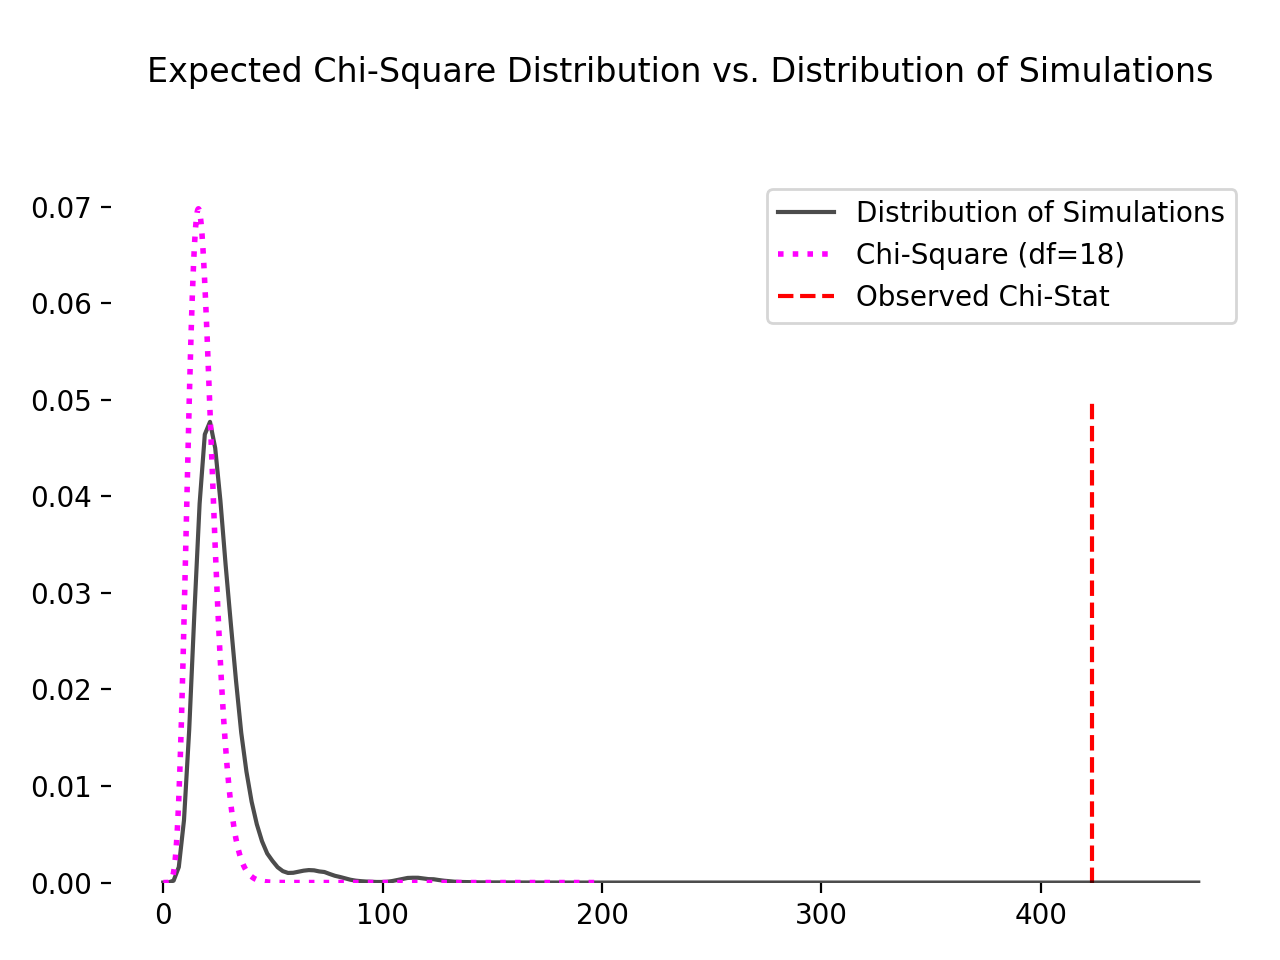

In [18]:
x = np.linspace(0, 200, 1000)
r = st.chi2.pdf(x, df=18)

fig, ax = plt.subplots()
#ax.hist(sim_chi_scores, bins=50, histtype="step", color="dimgray")
my_kde = sns.kdeplot(sim_chi_scores, color="black", alpha=.7)
plt.plot(x, r, linestyle=":", color="magenta", linewidth=2)
plt.box(False)
ax.set_ylabel("")
ax.vlines(ymin=0, ymax=.05, x=chi2, color="red", linestyle="--")
plt.title("\nExpected Chi-Square Distribution vs. Distribution of Simulations\n\n")
plt.legend(["Distribution of Simulations", "Chi-Square (df=18)", "Observed Chi-Stat"])
plt.tight_layout()
#plt.savefig("chisq.png", dpi=300)

**Reflection**

Violating the assumptions of the Chi-square test led to test results that are misleading, though less so than in the case of the f-test. Both the test and simulation called the results statistically significant. However, the p-value of the simulation was gigantic compared to the p-value of the test (.0001 vs 1.2e-78.)

<b>Final Test: Regression</b>

Finally I will compare a quantitative variable with another quantitative variable--i.e., a regression. I compare the age of customers with their credit limit, and do fine a small positive effect. But assumptions of Ordinary Least Squares are not met. So I run a simulation by shuffling the residuals. The results of the OLS regression are more or less confirmed by the simulation.

In [18]:
#Looking at correlations between the two variables.

df[["AGE", "LIMIT_BAL"]].corr()

,AGE,LIMIT_BAL
AGE,1.000000,0.145959
LIMIT_BAL,0.145959,1.000000


<IPython.core.display.Javascript object>


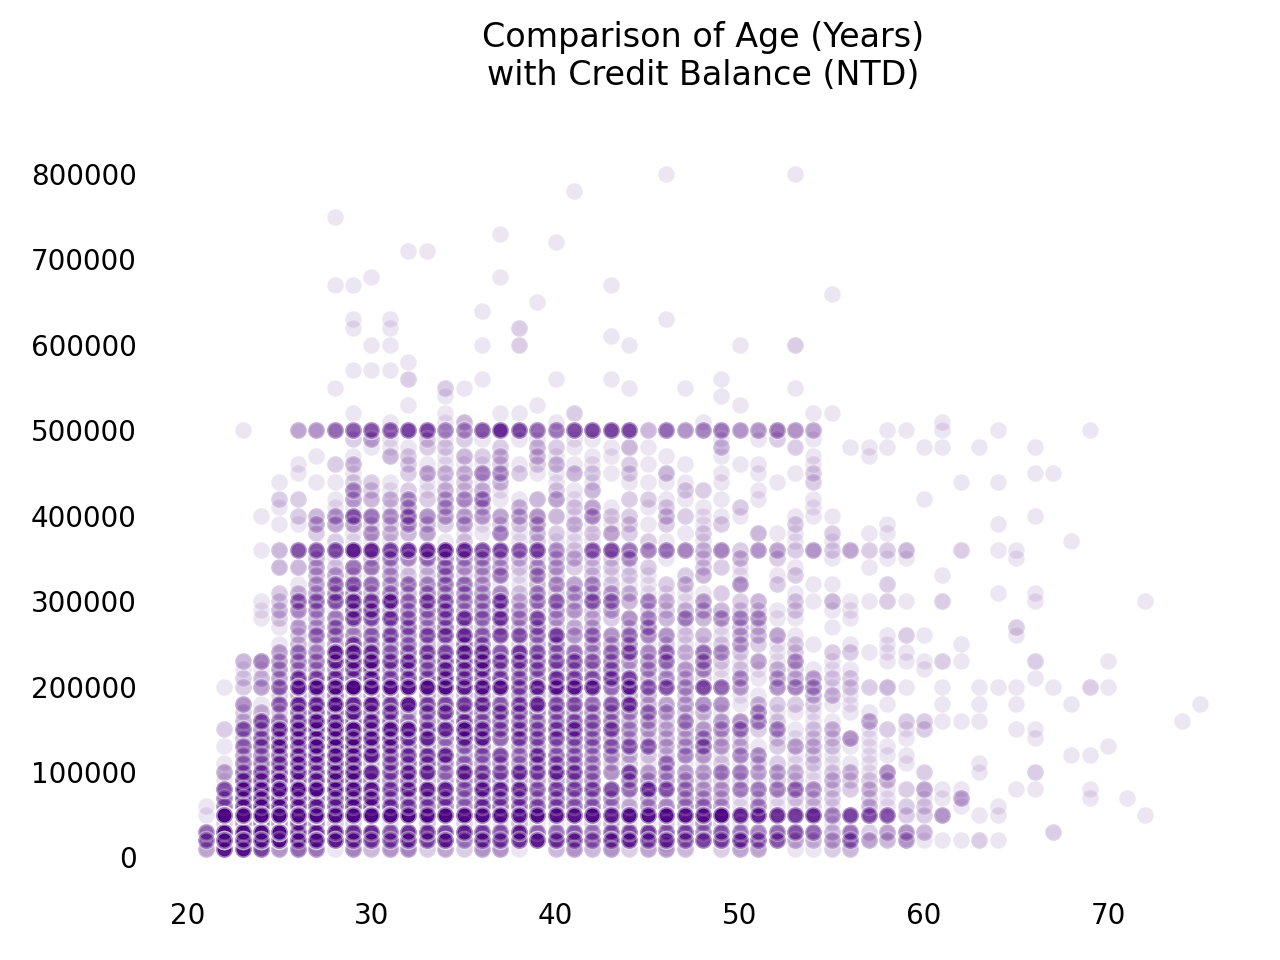

In [19]:
fig, ax = plt.subplots()
ax.scatter(df.AGE, df.LIMIT_BAL, alpha=.1, color="indigo", edgecolor="white")
plt.box(False)
ax.tick_params(bottom=False, left=False)
plt.title("Comparison of Age (Years)\nwith Credit Balance (NTD)\n")
plt.tight_layout()
#plt.savefig("age_balance_scatter.png", dpi=300)

In [20]:
#Running a regression

from statsmodels.regression import linear_model as lm
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


lindata = df[["AGE", "LIMIT_BAL"]]

lindata_scaled = scaler.fit_transform(lindata)

y = lindata_scaled[:, 1]
X = lindata_scaled[:, 0].reshape(-1, 1)

const = np.ones((10000, 1))

X = np.append(const, X, axis=1)

X
lin_model = lm.OLS(y, X)

results = lin_model.fit()

results.params

array([1.73472348e-18, 1.45959320e-01])

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     217.6
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           9.64e-49
Time:                        15:50:22   Log-Likelihood:                -14082.
No. Observations:               10000   AIC:                         2.817e+04
Df Residuals:                    9998   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.735e-18      0.010   1.75e-16      1.000      -0.019       0.019
x1             0.1460      0.010     14.752      0.000       0.127       0.165
==============================================================================
Omnibus:                     1111.436   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1512.698
Skew:                           0.927   Prob(JB):                         0.00
Kurtosis:                       3.442   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Interpeting the Results</b>

According to our test there is a small but real positive correlation between a customer's age and credit limit. We can say it is real because the p-value is so small as to be effectively non-existent. At the same time the effect is small. A difference in one standard deviation in age corresponds to a difference of .146 standard deviations in credit limit. In other words, for each additional year of age a customer will have, on average, an additional NTU 2041.93, or USD 63.30, to their credit limit.

The intercept of our model is effectively zero, but this is what we should expect, given that both variables were normalized.

This information is barely predictive at all, however, because of considerable variation at each age level. $r^{2}$ of the regression line is .021.

Some of the math is below.

In [22]:
#figuring out how much money each of year of age adds, on average, to the credit limit.

.146/df.AGE.std() * df.LIMIT_BAL.std()

2041.9323193033679

In [23]:
#Converting NTU to USD.

2041.93 * .031

63.29983

<b>Checking the assumptions</b>

We will see here that the residuals are not normally distributed, nor are they homoscedastic. This will lead to running a simulation to double-check the regression model.

<IPython.core.display.Javascript object>


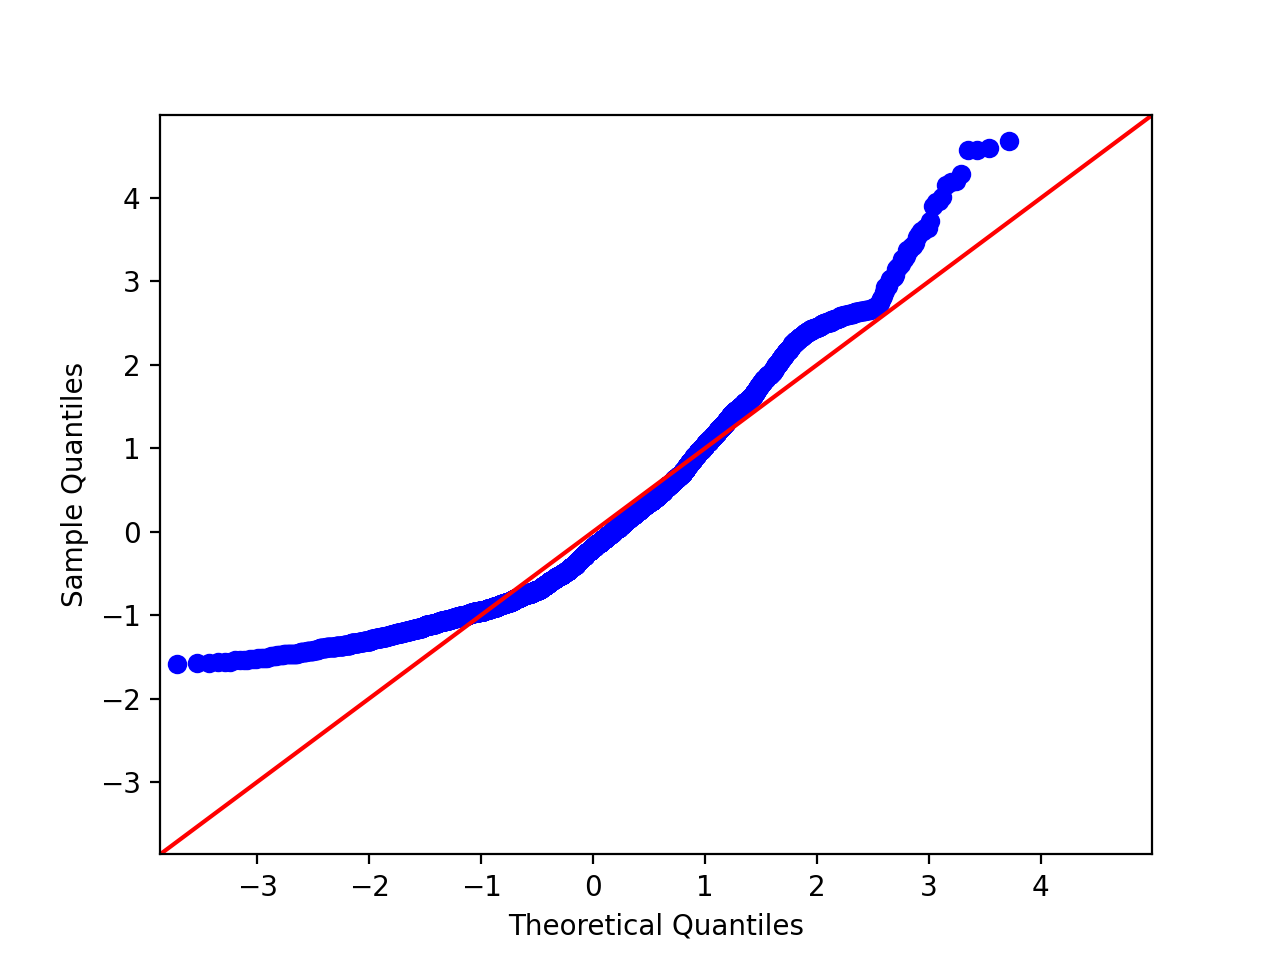

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [26]:
#checking normality of distribution of residuals

from statsmodels.graphics.gofplots import qqplot

y_hat = results.predict(X)

residuals = y - y_hat

fig = qqplot(data=residuals, line="45")
#plt.savefig("qqplot", dpi=200)

<IPython.core.display.Javascript object>


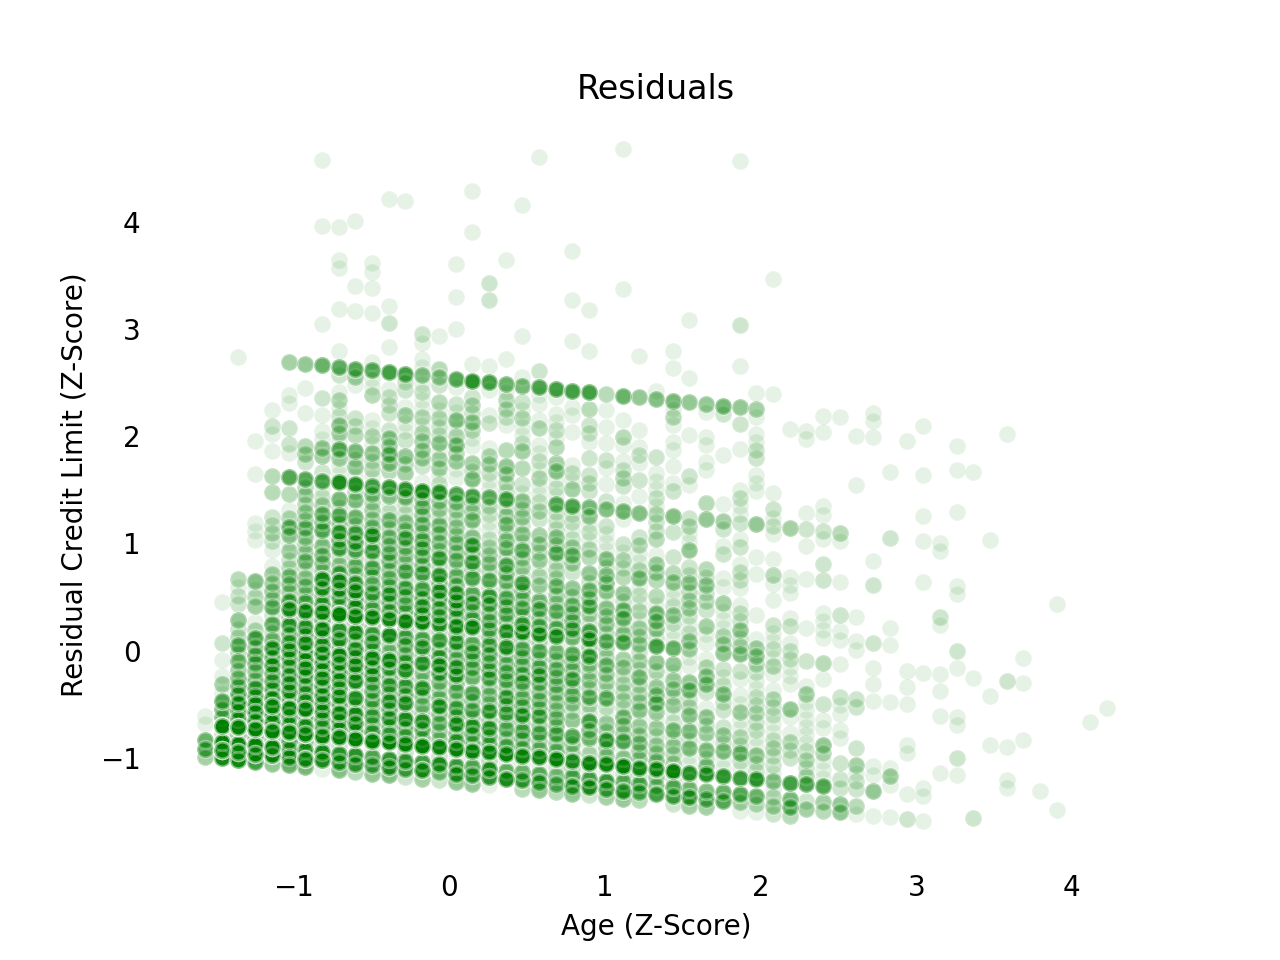

In [27]:
#checking for homoscedasticity
fig, ax = plt.subplots()

ax.scatter(X[:,1], residuals, color="green", alpha=.1, edgecolor="white")
plt.box(False)
ax.tick_params(bottom=False, left=False)
plt.title("Residuals")
ax.set_xlabel("Age (Z-Score)")
ax.set_ylabel("Residual Credit Limit (Z-Score)")
#plt.savefig("residuals.png", dpi=300)

In [29]:
#running the simulation to check the p-value and confidence interval of the slope of the regression.

cases = np.zeros((10000, 2))

for i in range(10000):
    
    rand = np.random.RandomState(seed=(6*i+1))

    rand_y = rand.choice(residuals, size=10000, replace=True)

    sim_model = lm.OLS(rand_y, X)
    sim_results = sim_model.fit()

    cases[i] = sim_results.params

    
m_s = cases[:, 1]
b_s = cases[:, 0]

p_m = np.mean(abs(m_s) >= .146)
CI_m = [.1447 + np.quantile(m_s, .025), .1447 + np.quantile(m_s, .975)]

p_b = np.mean(abs(b_s) > 1.735e-18)
CI_b = [1.735e-18 + np.quantile(b_s, .025), 1.735e-18 + np.quantile(m_s, .975)]

print(f"""
The results of running 10,000 simulations confirm that there is a statistically significant
relationship between age and credit limit, with a coefficient line of equal or greater
absolute magnitude arising by chance in {100*p_m:.2f}% of cases (e.g., p={p_m:.2g}). Based
on these simulations, the estimated .95 confidence interval of the coefficient is 
[{CI_m[0]:.3f}, {CI_m[1]:.3f}]. This is very close to the .95 CI of the model, [.127, .165].
""")



The results of running 10,000 simulations confirm that there is a statistically significant
relationship between age and credit limit, with a coefficient line of equal or greater
absolute magnitude arising by chance in 0.00% of cases (e.g., p=0). Based
on these simulations, the estimated .95 confidence interval of the coefficient is 
[0.125, 0.164]. This is very close to the .95 CI of the model, [.127, .165].



**Reflection**

In the case of the regression line, the results seem fairly robust despite the violating the assumptions of the model. When looking at the slope of the line, the p-value and CI from the simulation are very close to those provided by the test.